# Validation Under Imbalance and Drift
    Evaluating Models When Data Is Skewed and Non-Stationary
## Objective

This notebook provides a rigorous validation framework for scenarios where:

- Positive classes are rare

- Data distributions evolve over time

- Historical performance overstates future results

It answers:

    How do we validate models when the data we train on is not the data we deploy on?

## Why Standard Validation Fails

Standard validation assumes:

- Stable distributions

- Balanced targets

- Stationary relationships

In reality:

- Fraud rates change

- Customer behavior evolves

- Economic conditions shift

Validation must stress-test models against reality.

## Business Context

Critical in:

- Fraud detection

- Credit risk

- Churn modeling

- Demand forecasting

- Compliance monitoring

Failure modes are asymmetric and expensive.

## Imports and Dataset

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    confusion_matrix,
    classification_report
)


df = pd.read_csv("D:/GitHub/Data-Science-Techniques/datasets/Model-evaluation/bank_complaints.csv",
                parse_dates=["application_date"]
).sort_values("application_date")

X = df.drop(columns=["default", "customer_id", "application_date"])
y = df["default"]



df.head()

,customer_id,application_date,age,income,loan_amount,credit_score,utilization,delinquencies,default
0,1,2015-01-01 00:00:00.000000000,44.967142,41744.145757,14243.717707,683.941888,0.283200,0,0
1,2,2015-01-01 03:56:36.229811490,38.617357,40673.393570,29922.058669,708.144874,0.235214,0,0
2,3,2015-01-01 07:53:12.459622981,46.476885,24969.043128,16332.407062,697.055098,0.246711,0,0
3,4,2015-01-01 11:49:48.689434471,55.230299,45790.580761,18869.169625,616.104290,0.241291,1,0
4,5,2015-01-01 15:46:24.919245962,37.658466,20009.589843,25814.594863,670.688985,0.275783,1,0


# Inspect Class Imbalance Over Time

In [2]:
df["year"] = df["application_date"].dt.year

df.groupby("year")["default"].mean()


year
2015    0.011701
2016    0.011226
2017    0.014851
2018    0.016209
2019    0.023402
2020    0.020656
2021    0.022502
2022    0.040522
2023    0.034296
Name: default, dtype: float64

Observe drift in base rate.

# Time-Based Validation Strategy

In [3]:
tscv = TimeSeriesSplit(n_splits=5)


✔ Preserves causality
✔ Simulates production roll-forward

# Pipeline (Leakage-Safe)

In [4]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])


✔ Handles imbalance
✔ Avoids resampling leakage

# Rolling Validation Performance

In [5]:
roc_scores = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    pipeline.fit(X_train, y_train)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    roc_scores.append(roc_auc_score(y_test, y_prob))

roc_scores


[np.float64(0.5127283105022831),
 np.float64(0.44256506386503336),
 np.float64(0.5866832092638544),
 np.float64(0.6229999024739118),
 np.float64(0.586058993649846)]

## Performance Degradation Analysis

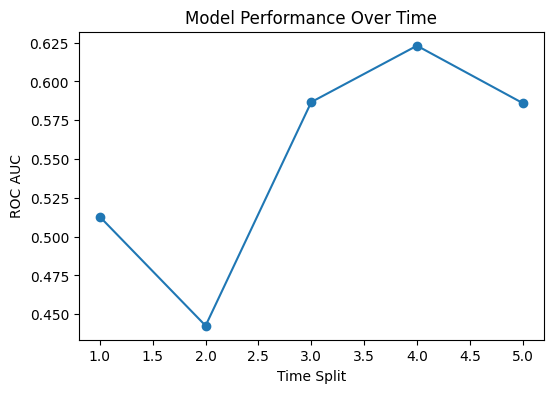

In [6]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(roc_scores) + 1), roc_scores, marker="o")
plt.xlabel("Time Split")
plt.ylabel("ROC AUC")
plt.title("Model Performance Over Time")
plt.show()


📉 Decline indicates concept drift.

## Precision–Recall Stability

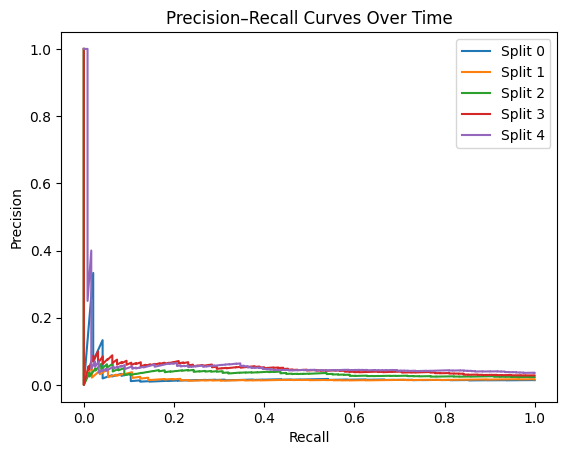

In [7]:
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    pipeline.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_prob = pipeline.predict_proba(X.iloc[test_idx])[:, 1]
    
    precision, recall, _ = precision_recall_curve(y.iloc[test_idx], y_prob)
    plt.plot(recall, precision, label=f"Split {i}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision–Recall Curves Over Time")
plt.show()


✔ Tracks minority-class degradation.

## Threshold Drift Sensitivity

In [8]:
threshold = 0.3

for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    pipeline.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_prob = pipeline.predict_proba(X.iloc[test_idx])[:, 1]
    preds = (y_prob >= threshold).astype(int)
    
    cm = confusion_matrix(y.iloc[test_idx], preds)
    print(f"Split {i}:\n{cm}\n")


Split 0:
[[ 386 2899]
 [   7   41]]

Split 1:
[[   2 3275]
 [   0   56]]

Split 2:
[[   0 3255]
 [   0   78]]

Split 3:
[[   0 3238]
 [   0   95]]

Split 4:
[[   0 3212]
 [   0  121]]



Fixed thresholds degrade under drift.

## Validation Recommendations Under Drift

| Problem               | Recommended Action |
| --------------------- | ------------------ |
| Base-rate shift       | Recalibrate        |
| Feature drift         | Monitor PSI        |
| Performance decay     | Retrain            |
| Threshold instability | Dynamic thresholds |


## – What NOT to Do

- ❌ Random cross-validation
- ❌ Static thresholds
- ❌ Accuracy-based evaluation
- ❌ Ignoring base rate drift
- ❌ Deploying without monitoring

## Summary Table

| Challenge | Tool               |
| --------- | ------------------ |
| Imbalance | PR curves          |
| Drift     | Time-based CV      |
| Stability | Rolling metrics    |
| Cost      | Threshold analysis |



## Key Takeaways

- Imbalance amplifies validation errors

- Time-aware validation is mandatory

- ROC alone is insufficient

- Thresholds must adapt

- Monitoring is part of validation

## Next Notebook
06_Model_Evaluation_and_Validation/

└── [07_model_comparison_and_selection.ipynb](07_model_comparison_and_selection.ipynb)

<br><br><br><br><br>



# Complete: [Data Science Techniques](https://github.com/lei-soares/Data-Science-Techniques)

- [00_Data_Generation_and_Simulation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/00_Data_Generation_and_Simulation)


- [01_Exploratory_Data_Analysis_(EDA)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/01_Exploratory_Data_Analysis_(EDA))


- [02_Data_Preprocessing](https://github.com/lei-soares/Data-Science-Techniques/tree/main/02_Data_Preprocessing)


- [03_Feature_Engineering](https://github.com/lei-soares/Data-Science-Techniques/tree/main/03_Feature_Engineering)


- [04_Supervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/04_Supervised_Learning)

    - [Regression Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/01_regression_models)
    
    - [Classification Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/02_classification_models)


- [05_Unsupervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/05_Unsupervised_Learning)


- [06_Model_Evaluation_and_Validation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/06_Model_Evaluation_and_Validation)


- [07_Model_Tuning_and_Optimization](https://github.com/lei-soares/Data-Science-Techniques/tree/main/07_Model_Tuning_and_Optimization)


- [08_Interpretability_and_Explainability](https://github.com/lei-soares/Data-Science-Techniques/tree/main/08_Interpretability_and_Explainability)


- [09_Pipelines_and_Workflows](https://github.com/lei-soares/Data-Science-Techniques/tree/main/09_Pipelines_and_Workflows)


- [10_Natural_Language_Processing_(NLP)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/10_Natural_Language_Processing_(NLP))


- [11_Time_Series](https://github.com/lei-soares/Data-Science-Techniques/tree/main/11_Time_Series)


- [12_Anomaly_and_Fraud_Detection](https://github.com/lei-soares/Data-Science-Techniques/tree/main/12_Anomaly_and_Fraud_Detection)


- [13_Imbalanced_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/13_Imbalanced_Learning)


- [14_Deployment_and_Production_Concepts](https://github.com/lei-soares/Data-Science-Techniques/tree/main/14_Deployment_and_Production_Concepts)


- [15_Business_and_Experimental_Design](https://github.com/lei-soares/Data-Science-Techniques/tree/main/15_Business_and_Experimental_Design)




<br><br><br><br><br>

[Panfugo Dados](www.pantufodados.com)


[Pantufo Dados - YouTube Channel](https://www.youtube.com/@pantufodados)